# MACHINE LEARNING: ENVIRONMENT PREDICTION

In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kruskal

from sklearn.decomposition import PCA

from skbio import TreeNode
from skbio.diversity import alpha_diversity, beta_diversity
from skbio.stats.ordination import pcoa

In [107]:
import numpy as np
import pandas as pd

np.random.seed(42)

# Parameters
n_otus = 300
n_samples = 60
environments = ["Soil", "Water", "Animal", "Human"]

# Assign environments
metadata = pd.DataFrame({
    "SampleID": [f"S{i+1}" for i in range(n_samples)],
    "Environment": np.repeat(environments, n_samples // len(environments))
}).set_index("SampleID")

# Simulate OTU abundances
otu_data = {}

for sample in metadata.index:
    env = metadata.loc[sample, "Environment"]
    
    if env == "Soil":
        counts = np.random.negative_binomial(5, 0.3, n_otus)
    elif env == "Water":
        counts = np.random.negative_binomial(3, 0.4, n_otus)
    elif env == "Animal":
        counts = np.random.negative_binomial(4, 0.35, n_otus)
    else:  # Human
        counts = np.random.negative_binomial(6, 0.25, n_otus)
    
    otu_data[sample] = counts

otu_table = pd.DataFrame(otu_data, index=[f"OTU_{i+1}" for i in range(n_otus)])

otu_table.shape, metadata.shape
otu_table.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S51,S52,S53,S54,S55,S56,S57,S58,S59,S60
OTU_1,15,9,22,12,12,9,4,12,18,6,...,43,16,22,10,18,5,18,17,27,31
OTU_2,11,16,9,19,4,7,5,5,10,19,...,8,8,7,10,22,3,15,21,13,14
OTU_3,7,3,16,12,3,13,13,12,2,4,...,8,15,13,4,5,32,9,36,30,30
OTU_4,13,8,13,8,6,19,2,13,11,32,...,8,31,29,8,16,19,17,8,10,29
OTU_5,7,15,7,13,11,6,19,10,11,11,...,23,13,7,16,16,19,10,15,17,16


In [108]:
# Remove OTUs with very low abundance
otu_table = otu_table.loc[otu_table.sum(axis=1) > 10]

# Relative abundance normalization
otu_rel = otu_table.div(otu_table.sum(axis=0), axis=1)

### STEP 1: PREPARE FEATURES

In [109]:
X = otu_rel.T  # samples × OTUs
y = metadata["Environment"]


### STEP 2: TRAIN A RANDOM FOREST

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

      Animal       0.25      0.20      0.22         5
       Human       0.30      0.75      0.43         4
        Soil       0.67      0.40      0.50         5
       Water       1.00      0.25      0.40         4

    accuracy                           0.39        18
   macro avg       0.55      0.40      0.39        18
weighted avg       0.54      0.39      0.38        18



In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

### STEP 3: VISUALIZE PERFORMANCE

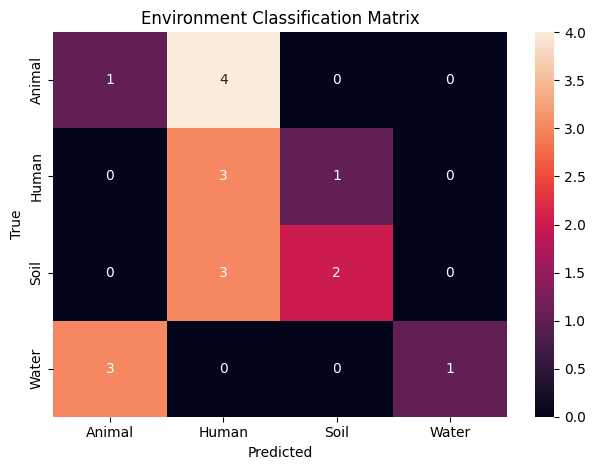

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Environment Classification Matrix")
plt.tight_layout()
plt.show()


### STEP 4: FEATURE IMPORTANCE

In [ ]:
importances = pd.Series(
    clf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

top_otus = importances.head(20)
top_otus


OTU_32     0.014557
OTU_249    0.011958
OTU_59     0.011113
OTU_134    0.009777
OTU_160    0.008933
OTU_294    0.008828
OTU_79     0.008566
OTU_293    0.008552
OTU_190    0.008541
OTU_30     0.008525
OTU_233    0.008479
OTU_10     0.008160
OTU_268    0.007950
OTU_187    0.007726
OTU_40     0.007688
OTU_197    0.007670
OTU_42     0.007665
OTU_204    0.007156
OTU_27     0.006978
OTU_162    0.006974
dtype: float64

# NETWORK ANALYSIS (CO-OCCURRENCE + AMR LINKAGE)

Which taxa co-occur, and how are they linked to AMR genes?

### STEP 1: OTU CO-OCCURRENCE MATRIX

In [ ]:
from scipy.stats import spearmanr

corr, _ = spearmanr(otu_rel.T)
corr_df = pd.DataFrame(corr, index=X.columns, columns=X.columns)


Filter strong correlations:

In [ ]:
edges = corr_df.stack().reset_index()
edges.columns = ["OTU1", "OTU2", "Correlation"]

edges = edges[
    (edges["OTU1"] != edges["OTU2"]) &
    (edges["Correlation"].abs() > 0.6)
]
edges.head()

,OTU1,OTU2,Correlation


### STEP 2: BUILD NETWORK

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(
    edges,
    "OTU1",
    "OTU2",
    edge_attr="Correlation"
)

### STEP 3: ADD AMR GENE ATTRIBUTES

In [ ]:
import numpy as np
import pandas as pd

phyla = [
    "Proteobacteria",
    "Firmicutes",
    "Bacteroidota",
    "Actinobacteriota",
    "Acidobacteriota",
    "Cyanobacteria"
]

genera = {
    "Proteobacteria": ["Pseudomonas", "Escherichia", "Rhizobium"],
    "Firmicutes": ["Bacillus", "Clostridium", "Lactobacillus"],
    "Bacteroidota": ["Bacteroides", "Prevotella"],
    "Actinobacteriota": ["Streptomyces", "Corynebacterium"],
    "Acidobacteriota": ["Acidobacterium"],
    "Cyanobacteria": ["Synechococcus"]
}

In [ ]:
taxonomy = []

for otu in otu_table.index:
    phylum = np.random.choice(phyla, p=[0.25, 0.25, 0.2, 0.15, 0.1, 0.05])
    genus = np.random.choice(genera[phylum])
    
    taxonomy.append({
        "OTU": otu,
        "Phylum": phylum,
        "Genus": genus
    })

taxonomy_df = pd.DataFrame(taxonomy).set_index("OTU")
taxonomy_df.head()

,Phylum,Genus
OTU,,
OTU_1,Firmicutes,Clostridium
OTU_2,Cyanobacteria,Synechococcus
OTU_3,Actinobacteriota,Corynebacterium
OTU_4,Proteobacteria,Escherichia
OTU_5,Firmicutes,Bacillus


In [ ]:
amr_genes = [
    "blaTEM",     # beta-lactam
    "tetM",       # tetracycline
    "ermB",       # macrolide
    "sul1",       # sulfonamide
    "vanA",       # vancomycin
    "mcr-1"       # colistin
]


In [ ]:
amr_assignment = {}

for otu in otu_table.index:
    phylum = taxonomy_df.loc[otu, "Phylum"]
    
    if phylum in ["Proteobacteria", "Firmicutes"]:
        genes = np.random.choice(amr_genes, size=np.random.randint(0, 3), replace=False)
    else:
        genes = np.random.choice(amr_genes, size=np.random.randint(0, 1), replace=False)
    
    amr_assignment[otu] = list(genes)

In [ ]:
# Ensure all OTUs exist as nodes, then set attributes safely
missing = set(otu_table.index) - set(G.nodes())
if missing:
    G.add_nodes_from(missing)

amr_str = {otu: ",".join(genes) if genes else "None" for otu, genes in amr_assignment.items()}
nx.set_node_attributes(G, amr_str, name="AMR")
nx.set_node_attributes(G, taxonomy_df["Phylum"].to_dict(), name="Phylum")
nx.set_node_attributes(G, taxonomy_df["Genus"].to_dict(), name="Genus")

# Quick sanity check
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
list(G.nodes(data=True))[:5]

Nodes: 300, Edges: 0


[('OTU_102',
  {'AMR': 'None',
   'Phylum': np.str_('Firmicutes'),
   'Genus': np.str_('Clostridium')}),
 ('OTU_111',
  {'AMR': 'mcr-1',
   'Phylum': np.str_('Firmicutes'),
   'Genus': np.str_('Lactobacillus')}),
 ('OTU_36',
  {'AMR': 'tetM',
   'Phylum': np.str_('Proteobacteria'),
   'Genus': np.str_('Rhizobium')}),
 ('OTU_66',
  {'AMR': 'None',
   'Phylum': np.str_('Bacteroidota'),
   'Genus': np.str_('Prevotella')}),
 ('OTU_11',
  {'AMR': 'None',
   'Phylum': np.str_('Cyanobacteria'),
   'Genus': np.str_('Synechococcus')})]

### STEP 4: VISUALIZE NETWORK

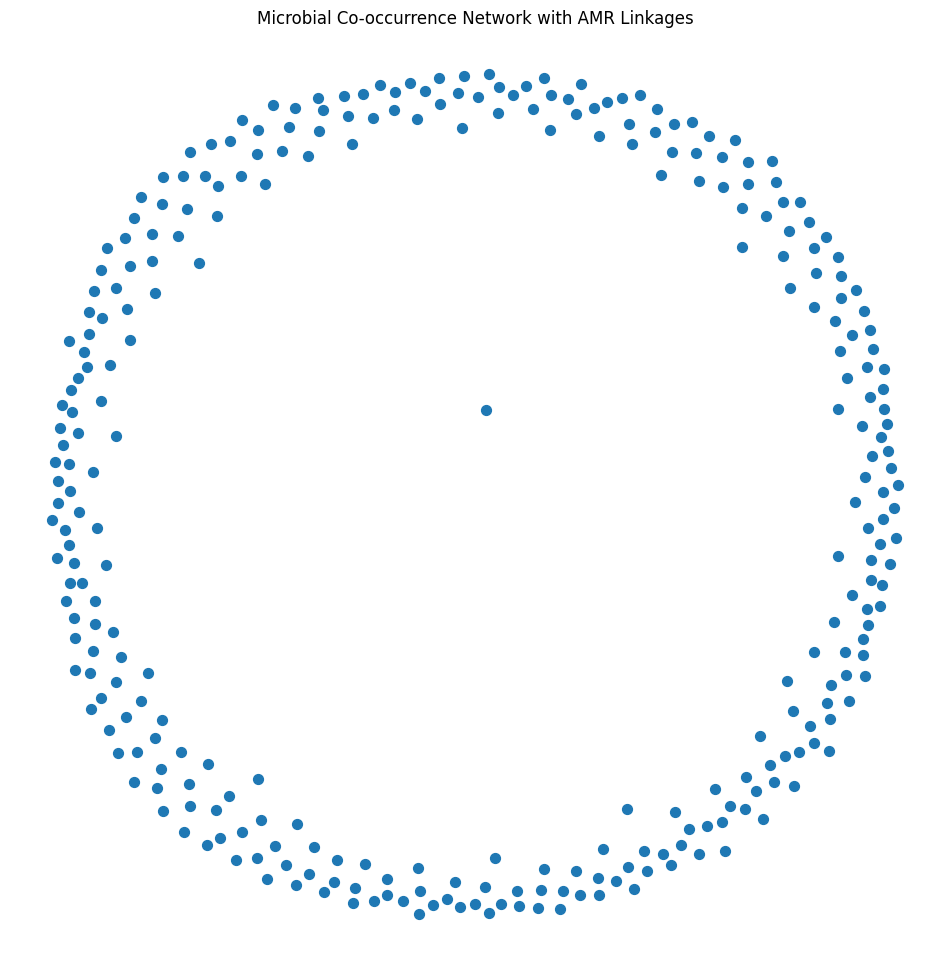

In [ ]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)

plt.title("Microbial Co-occurrence Network with AMR Linkages")
plt.axis("off")
plt.show()


### Interpretation:
Highly connected OTUs may represent keystone taxa and potential AMR dissemination hubs.